# Python Imports

In [ ]:
!pip install pandas_schema
!pip install python-louvain
!pip install python-highcharts
!pip install bokeh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 747.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-highcharts: filename=python_highcharts-0.4.2-py3-none-any.whl size=60694 sha256=81dd78bd819472b02f0acb34e1266489404850dd5ed183dd13d81c7b72ca7564
  Stored in directory: /root/.cache/pip/wheels/2b/99/eb/ad9e34c0f50b8a961510d814ee25dee8a293e91090bb80244f
Successfully built python-highcharts


In [ ]:
import re
import datetime
import numpy as np
import pandas as pd
import csv
import random
from google.colab import files
import pandas as pd
import pandas_schema
from pandas_schema import Column
from pandas_schema.validation import CustomElementValidation
import numpy as np
from decimal import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx as nx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Plasma256, d3, Turbo256
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
output_notebook()

# Utility Functions

In [ ]:
default_date_format ='%d/%m/%Y'
#
def DownloadDataFrame(df, filename):
  df.to_csv(filename, encoding = 'utf-8-sig', index=False, quoting=csv.QUOTE_NONNUMERIC)
  files.download(filename)
#
def ResetDFIndex(df):
  df.index = pd.RangeIndex(len(df.index))
  df.index = range(len(df.index))
  return df
#
def CreateSubDataSet(df, columns, unique, sort):
  df = CreateDatasetFromColabUsers(df)[columns].copy()
  if(sort):
    df = df.sort_values(sort, ascending=True)
    if(unique):
      idx = df[sort].drop_duplicates().index
      event_types = df.loc[idx,:]
  return ResetDFIndex(event_types)
#
def ExtractEventTypes(df, download):
  event_type_ids = CreateSubDataSet(df, ['event_type_id', 'event_type_name'], True, 'event_type_id')
  print(event_type_ids.shape)
  event_type_names = CreateSubDataSet(df, ['event_type_id', 'event_type_name'], True, 'event_type_name')
  print(event_type_names.shape)
  if(len(event_type_ids) != len(event_type_names)):
    print("event_type_id and event_type_name counts are different.", len(event_type_ids), "ids", len(event_type_names), "names")
  if(download):
    DownloadDataFrame(event_type_ids, "event_type_ids.csv")
    DownloadDataFrame(event_type_names, "event_type_names.csv")
  return event_type_ids if len(event_type_ids) < len(event_type_names) else event_type_names
#
def check_decimal(dec):
    try:
        Decimal(dec)
    except InvalidOperation:
        return False
    return True
#
def check_int(num):
    try:
        int(num)
    except ValueError:
        return False
    return True
#
def check_string(test_string):
    return check_null(test_string) and len(str(test_string)) > 0
#
def check_date(date):
  try:
      datetime.datetime.strptime(date, default_date_format)
      return True
  except ValueError:
      return False
  #return check_string(date) and re.match(r'(\d{4})-(\d{2})-(\d{2}) (\d{1,2}):(\d{2})', date) is not None
#
print("check_date should be false: ", check_date(""))
print("check_date should be false: ", check_date("2022-05-18"))
print("check_date should be true: ", check_date("03/03/2013"))
def check_null(d):
    return not(d is None)
#
# define validation elements
decimal_validation = [CustomElementValidation(lambda d: check_decimal(d), 'invalid decimal')]
int_validation = [CustomElementValidation(lambda i: check_int(i), 'invalid integer')]
null_validation = [CustomElementValidation(lambda d: check_null(d), 'field cannot be null')]
string_validation = [CustomElementValidation(lambda s: check_string(s), 'invalid string')]
date_validation = [CustomElementValidation(lambda s: check_date(s), 'invalid date')]
#
#
def validate_colab_events(file, parse_dates):
    print("validating colab_events file")
    # read the data
    data = ReadCSV(file, parse_dates)
    # define validation schema
    schema = pandas_schema.Schema([
            Column('event_id', null_validation+int_validation),
            Column('user_id', null_validation+int_validation),
            Column('description', string_validation),
            Column('status', null_validation + string_validation),
            Column('created_at', date_validation),
            Column('event_type_id', null_validation + int_validation),
            Column('event_type_name', null_validation + string_validation)
            ])
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if(len(errors) > 0):
      # save data
      #data_clean.update('"' + data_clean[['description', 'status', 'created_at', 'event_type_name']].astype(str) + '"')
      #data_clean['event_type_id'] = data_clean['event_type_id'].astype('int')
      print(data.shape)
      print(data_clean.shape)
      #DownloadDataFrame(data_clean, "colab_events_cleaned.csv")
      DownloadDataFrame(pd.DataFrame({'errors':errors}), "data_errors.txt")
      print("Errors found on CSV schema. Check out the data_errors.txt")
      return False
    else:
      print("File is clean")
      return True
#
def tipify_colab_events(df):
  df.fillna(-1, inplace=True)
  df['event_id'] = df['event_id'].astype('int')
  df['user_id'] = df['user_id'].astype('int')
  df['event_type_id'] = df['event_type_id'].astype('int')
  return df
#
def validate_colab_users(file, parse_dates):
    # read the data
    print("validating colab_users file")
    data = ReadCSV(file, parse_dates).head(1)
    # define validation schema
    schema = pandas_schema.Schema([
            Column('colab_user_id', null_validation+int_validation),
            Column('gender', null_validation),
            Column('birth_date', null_validation),
            Column('city_id', null_validation),
            Column('city_name', string_validation),
            Column('state_id', null_validation),
            Column('state_name', null_validation + string_validation),
            Column('created_at', date_validation),
            Column('last_sign_in_at', date_validation),
            Column('device', {})
            ])
    print(data.columns)
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if(len(errors) > 0):
      # save data
      print(data.shape)
      print(data_clean.shape)
      #DownloadDataFrame(data_clean, "colab_users_cleaned.csv")
      DownloadDataFrame(pd.DataFrame({'errors':errors}), "user_errors.txt")
      print("Errors found on CSV schema. Check out the user_errors.txt")
      return False
    else:
      print("File is clean")
      return True
#
def tipify_colab_users(df):
  df.fillna("", inplace=True)
  df['colab_user_id'] = df['colab_user_id'].astype('int')
  df['city_id'] = df['city_id'].astype('int')
  df['state_id'] = df['state_id'].astype('int')
  return df
#
def tipify_colab_followers(df):
  df.fillna(-1, inplace=True)
  df['source'] = df['source'].astype('int')
  df['target'] = df['target'].astype('int')
  return df
#
def CreateDatasetFromColabEvents(df):
  dataset = df.copy()
  return dataset
#
#
def CreateDatasetFromColabUsers(df):
  dataset = df.copy()
  return dataset
#
def ReadCSV(filename, parse_dates):
  df = pd.read_csv(filename,
                           parse_dates=parse_dates,
                           low_memory=False,
                           quoting=csv.QUOTE_NONNUMERIC,
                           quotechar='"')
  if(parse_dates):
    for field in parse_dates:
      try:
        df[field] = pd.to_datetime(df[field])
        df[field] = df[field].dt.strftime(default_date_format)
      except ValueError:
        print("error parsing date", df[field])
  #df[parse_dates].fillna(0, inplace=True)
  #df[parse_dates] = pd.to_datetime(df[parse_dates])
  #df[parse_dates] = df[parse_dates].dt.strftime('%d/%m/%Y')
  return df
#
def ReadAndValidateColabUsers(file):
  parse_dates = ['created_at', 'last_sign_in_at']
  if (validate_colab_users(file, parse_dates)):
    colab_users = tipify_colab_users(ReadCSV(file, parse_dates))
    return colab_users
#
def ReadAndValidateColabEvents(file):
  parse_dates = ['created_at']
  if (validate_colab_events(file, parse_dates)):
    colab_events = tipify_colab_events(ReadCSV(file, parse_dates))
    return colab_events
#

check_date should be false:  False
check_date should be false:  False
check_date should be true:  True


# Importando dados dos CSV

In [ ]:
#cleaning up users file. not longer needed
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1iRUwwuf1d-rAI2DhhNy4Z4CnLDchghzi&export=download" #New File (all data)
#colab_users = ReadCSV(colab_users_url, None)
#colab_users = tipify_colab_users(colab_users)
#colab_users['last_sign_in_at'].fillna("-1", inplace=True)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['created_at'] = colab_users.apply(lambda row: row['created_at'][0:len("2013-03-03 15:48:07")] if row['created_at'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = colab_users.apply(lambda row: row['last_sign_in_at'] if row['last_sign_in_at'] != "-1" else None, axis=1)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['birth_date'] = colab_users['birth_date'].dt.strftime('%Y-%m-%d')

#colab_users['device'] = colab_users.apply(lambda row: row['device'] if row['device'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = pd.to_datetime(colab_users['last_sign_in_at'])
#colab_users
#DownloadDataFrame(colab_users, "colab_users_cleaned.csv")

In [ ]:
# arquivo com usuários e seguidores obtido a partir do merge dos 2 csvs
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data) - Dirty
#colab_users_url = "https://drive.google.com/uc?id=1wNkAuqNSPTIY2dujmoy8r-oqV_EioiPi&export=download" #New File (all data) - Clean
colab_users_url = "https://drive.google.com/uc?id=1_rgS5CtYDFbU5viohhJueVKBz7C4zS7h&export=download" #05-20 File (all data) - Clean
colab_users = ReadAndValidateColabUsers(colab_users_url)
print(colab_users.shape)
colab_users.head(1)

validating colab_users file


<ipython-input-5-7eea4fd92c03>:168: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filename,
<ipython-input-5-7eea4fd92c03>:168: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filename,
<ipython-input-5-7eea4fd92c03>:176: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[field] = pd.to_datetime(df[field])


error parsing date 0        12/05/2020
1        17/05/2022
2        07/11/2021
3        21/03/2019
4        21/03/2019
            ...    
50761    19/05/2022
50762    19/05/2022
50763    19/05/2022
50764    19/05/2022
50765    19/05/2022
Name: last_sign_in_at, Length: 50766, dtype: object
Index(['colab_user_id', 'gender', 'birth_date', 'city_id', 'city_name',
       'state_id', 'state_name', 'created_at', 'last_sign_in_at', 'device'],
      dtype='object')
File is clean


<ipython-input-5-7eea4fd92c03>:168: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filename,
<ipython-input-5-7eea4fd92c03>:168: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filename,
<ipython-input-5-7eea4fd92c03>:176: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[field] = pd.to_datetime(df[field])


error parsing date 0        12/05/2020
1        17/05/2022
2        07/11/2021
3        21/03/2019
4        21/03/2019
            ...    
50761    19/05/2022
50762    19/05/2022
50763    19/05/2022
50764    19/05/2022
50765    19/05/2022
Name: last_sign_in_at, Length: 50766, dtype: object
(50766, 10)


,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device
0,1,male,1982-06-28,2916,Recife,16,Pernambuco,03/03/2013,12/05/2020,-1


In [ ]:
gender_counts = colab_users["gender"].value_counts()
print(gender_counts)
DownloadDataFrame(gender_counts, "gender_counts.csv")

male            30494
female          19555
-1                335
others            274
not_informed       92
non_binary         16
Name: gender, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#colab_events_url = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
#colab_events_url = "https://drive.google.com/uc?id=1jD3sY5jeDdCIb9M7EnCC6QVCI2RmKDqa&export=download" #05/19 file (all data)
#colab_events_url = "https://drive.google.com/uc?id=1pC9m4-k4e_I98MA_8G9mF-h6wCntd1Qu&export=download" #05/19 file (all data) - Clean
colab_events_url = "https://drive.google.com/uc?id=1Q-wSaTZGdP7xzsYFGV5E58feEN3e49yL&export=download"  #05/20 File(all data) - Clean
colab_events = ReadAndValidateColabEvents(colab_events_url)
print(colab_events.shape)
colab_events.head(1)
colab_events

validating colab_events file
File is clean
(328876, 7)


,event_id,user_id,description,status,created_at,event_type_id,event_type_name
0,5,623,Carro estacionado na calçada em Edelson Cabele...,RECUSADO,06/03/2013,7575,Ponto de infração de trânsito recorrente
1,8,68,Estacionamento da própria Prefeitura próximo a...,RECUSADO,07/03/2013,7575,Ponto de infração de trânsito recorrente
2,9,166,"Na esquina com a rua da Aurora, calçada da Com...",RECUSADO,07/03/2013,7546,Calçada irregular
3,10,164,Todos os dias a concessionária Auto Mar estaci...,RECUSADO,08/03/2013,7575,Ponto de infração de trânsito recorrente
4,11,733,"Diariamente, até mesmo em frente a prédio da p...",RECUSADO,08/03/2013,7575,Ponto de infração de trânsito recorrente
...,...,...,...,...,...,...,...
328871,376063,425243,retirado,NOVO,19/05/2022,9908,Entulho na calçada/via pública
328872,376064,681506,Conserto em caráter do buraco no asfalto... As...,NOVO,19/05/2022,9978,Conservação (via pública)
328873,376065,253059,"Olá, gostaria de solicitar o desentupimento do...",NOVO,19/05/2022,9928,Bueiro entupido
328874,376066,253059,Endereço correto rua Riachuelo 140 rocha Sobri...,NOVO,19/05/2022,9908,Entulho na calçada/via pública


In [ ]:
def find_and_print_user_by_id(df, user_id):
    user_row = df[df['user_id'] == user_id]
    if not user_row.empty:
        print(user_row)
    else:
        print(f"No row found with colab_user_id {user_id}")
##
find_and_print_user_by_id(colab_events, 196613)

No row found with colab_user_id 196613


In [ ]:
missing_user_ids = {196613, 180235, 163872, 65579, 180271, 139327, 180288, 180296, 319561, 180300, 65616, 131152, 319568, 196713, 475243, 204911, 180335, 180349, 131228, 671907, 65704, 24745, 180394, 180399, 65712, 164021, 180407, 164028, 57532, 41154, 180423, 188629, 123096, 57561, 180445, 172256, 114914, 319721, 65772, 196848, 24817, 57587, 139508, 286967, 164094, 180480, 303365, 180488, 188681, 155916, 180493, 155929, 196891, 41243, 188699, 57630, 65824, 41249, 65826, 180520, 57645, 98608, 655668, 41270, 188726, 172346, 74048, 188741, 90442, 180557, 172375, 188766, 65887, 188768, 156005, 467302, 41319, 164200, 319846, 123242, 172395, 123244, 180590, 41327, 287093, 57728, 98690, 172420, 90503, 180624, 180625, 401811, 147859, 197025, 180642, 131493, 8613, 90534, 115122, 213426, 672196, 49606, 164301, 164302, 254424, 49634, 180706, 180711, 180712, 197102, 90606, 8688, 188917, 188921, 270845, 90626, 197127, 57866, 188943, 147985, 188947, 147995, 123421, 229922, 197158, 180778, 131631, 74287, 66102, 197174, 311865, 90684, 311872, 205379, 66125, 66126, 369229, 139869, 66142, 180833, 246372, 320115, 115322, 328323, 90755, 180872, 164492, 57997, 197264, 58005, 58007, 66200, 197274, 197276, 164509, 221866, 98990, 205486, 352948, 58042, 189129, 66255, 66257, 131793, 189146, 66267, 180955, 271073, 172776, 189167, 58101, 180983, 197374, 180993, 164610, 353027, 197380, 123651, 66311, 25351, 287506, 58137, 131871, 189218, 25384, 66345, 320298, 320300, 66349, 66351, 295729, 66354, 189234, 181044, 197429, 41784, 353081, 320320, 131908, 164678, 181071, 140112, 181080, 58203, 164703, 230248, 164713, 222056, 181100, 197490, 99192, 189304, 66439, 246663, 189320, 189339, 189348, 181163, 197550, 672686, 328625, 246708, 328633, 164802, 189395, 132052, 173012, 213972, 148437, 164826, 164828, 115677, 164831, 164840, 361454, 164849, 181242, 246779, 173064, 132105, 132107, 132110, 156693, 58394, 189468, 99357, 99359, 164906, 99373, 197678, 123952, 99377, 132149, 189506, 74819, 189508, 189510, 189512, 164940, 164948, 115797, 164953, 173145, 189529, 140384, 124008, 164972, 58478, 99442, 99443, 58495, 99462, 99464, 296074, 214156, 459922, 189587, 189592, 99484, 205984, 25772, 124079, 189621, 181434, 58557, 197823, 189633, 410822, 132306, 181459, 181461, 132313, 189659, 255196, 189661, 197858, 181474, 173284, 58594, 189679, 115957, 189693, 189694, 75011, 451844, 50440, 230666, 148748, 148754, 58650, 58651, 58652, 132382, 165151, 320801, 214310, 156967, 189735, 124204, 58672, 189747, 271671, 75064, 50493, 148799, 75072, 189759, 132418, 189760, 132421, 58697, 42315, 222540, 165197, 222541, 181586, 132437, 181589, 173401, 42330, 181594, 58716, 181597, 337246, 58727, 132459, 206188, 197998, 58734, 58742, 58744, 132474, 58751, 42368, 198018, 42374, 189831, 124300, 58769, 189842, 58772, 9628, 58783, 58784, 58785, 26020, 58790, 189862, 58792, 34219, 58800, 58803, 263604, 91574, 91577, 189885, 132542, 189890, 148932, 58823, 58827, 165324, 165327, 58833, 58835, 181716, 173525, 255445, 58837, 58838, 58841, 181723, 198109, 181729, 26081, 58855, 181741, 337390, 26093, 181744, 58867, 214516, 181749, 58870, 58871, 58872, 58873, 58878, 116224, 165377, 181762, 189954, 189956, 214532, 189955, 58884, 58885, 58888, 58883, 58890, 189964, 230925, 58893, 165391, 157202, 198164, 58901, 132630, 58914, 58919, 165416, 189992, 411182, 42544, 132661, 58936, 190009, 116282, 58938, 222780, 75327, 58946, 190020, 165445, 75333, 951879, 58949, 91717, 58951, 132684, 271948, 132687, 271953, 58963, 149076, 58965, 190038, 165476, 190052, 362087, 173671, 58983, 58985, 190057, 58988, 190063, 58994, 58995, 190069, 59000, 149116, 198270, 59009, 198276, 59012, 173702, 173703, 173704, 59016, 190088, 59019, 18063, 198292, 198293, 345749, 75415, 75416, 124569, 59034, 190105, 190106, 18077, 59037, 59041, 190119, 190122, 59051, 132784, 132788, 26293, 132790, 173750, 116407, 59069, 345791, 345792, 345794, 345796, 272070, 296647, 108232, 59080, 124626, 75478, 124630, 59105, 190177, 149221, 165606, 354022, 165611, 165612, 26351, 190191, 190194, 42739, 116467, 190195, 59123, 157428, 59134, 935682, 476931, 190211, 132872, 18186, 272139, 116490, 149261, 190219, 362263, 157465, 280348, 59169, 116514, 91937, 26404, 59173, 108326, 116524, 190252, 59182, 214840, 132922, 255804, 214845, 190273, 116559, 59220, 149349, 59249, 190325, 173945, 132988, 59260, 59261, 59262, 59263, 190333, 305038, 165778, 190355, 59286, 214935, 239512, 59296, 59301, 133033, 272306, 174004, 313271, 190398, 198594, 59331, 190409, 59339, 59344, 59356, 59357, 174046, 149470, 59360, 59361, 190442, 100332, 108529, 59377, 206837, 165879, 59386, 296965, 149510, 215047, 165899, 165901, 83990, 190488, 165925, 198696, 190510, 190515, 190521, 190527, 59459, 337991, 198728, 108620, 133198, 108623, 338000, 59472, 108626, 43098, 190555, 133216, 59490, 264296, 190573, 133230, 149619, 141430, 149622, 59512, 84093, 133247, 125063, 190602, 133260, 59534, 75926, 59542, 59543, 133276, 59555, 75940, 75941, 190633, 182442, 207022, 133297, 59571, 108725, 354489, 198847, 59583, 174273, 59585, 174277, 75976, 166093, 133333, 190684, 182494, 18654, 198881, 313574, 59625, 59626, 190699, 133356, 43248, 190707, 248052, 59646, 141567, 190722, 35078, 190728, 59658, 133389, 174357, 76054, 59672, 76060, 43293, 35105, 43301, 174377, 190767, 59696, 174385, 43314, 59699, 43319, 43320, 59704, 190778, 59707, 190780, 43325, 43328, 59715, 59720, 59721, 59724, 198991, 190801, 59730, 190805, 43350, 43352, 199001, 43354, 10586, 84315, 59737, 59742, 76127, 190814, 133475, 59748, 59750, 190826, 59756, 76141, 84336, 59761, 59762, 199027, 43383, 59767, 59769, 59770, 43387, 59774, 362889, 133513, 43401, 190857, 59787, 362904, 223642, 59807, 59808, 199075, 35236, 125347, 190885, 76199, 248233, 59817, 436652, 190892, 59822, 59823, 43442, 59826, 59828, 125369, 190905, 149947, 190909, 59838, 59839, 354753, 59844, 59849, 18893, 59860, 10711, 133597, 190952, 149996, 59892, 174585, 59897, 59899, 59903, 150019, 18952, 150026, 59920, 190999, 43547, 59931, 43554, 199203, 43556, 18980, 150053, 313895, 191010, 191016, 43562, 109103, 240177, 125489, 59954, 207412, 59958, 43577, 150074, 59963, 76349, 191039, 59977, 43595, 59983, 322127, 191057, 76373, 313942, 35415, 199255, 215640, 43611, 60005, 133734, 43623, 60009, 43626, 60011, 125549, 43630, 150126, 199280, 191085, 43636, 43639, 109175, 199289, 43643, 43644, 60027, 191106, 43652, 150149, 43657, 43658, 191115, 43661, 43663, 43669, 43670, 174745, 125598, 43681, 543394, 191142, 43688, 150184, 174762, 43691, 420521, 191153, 174771, 43704, 191160, 133820, 43710, 43712, 60098, 428739, 43723, 43724, 191182, 240342, 43737, 60124, 445149, 125662, 43751, 43752, 273130, 281324, 150252, 60145, 191224, 191228, 43773, 60157, 125697, 60161, 191244, 11025, 76568, 125724, 150301, 125727, 150318, 215855, 19248, 191278, 191282, 322356, 207675, 314172, 174909, 133950, 133956, 363342, 699235, 265062, 191341, 125807, 60271, 60282, 134023, 125832, 60300, 183186, 240531, 134036, 60311, 60317, 60319, 60329, 125867, 215980, 101298, 35762, 76722, 76724, 76726, 60345, 76730, 273344, 60353, 76746, 93132, 117710, 158671, 43996, 76766, 191454, 101344, 224229, 363500, 76780, 60401, 134130, 265206, 183293, 76805, 355336, 191497, 60429, 166945, 19492, 76838, 117800, 60468, 134197, 126005, 191542, 60475, 117823, 101451, 183371, 183378, 281683, 126036, 76885, 134233, 60509, 314464, 150624, 183392, 60513, 191588, 183402, 109675, 183404, 109679, 35956, 76926, 109695, 109697, 109704, 109708, 60560, 109713, 109718, 142486, 60568, 191641, 191645, 60577, 289954, 453795, 183460, 109734, 11431, 175272, 60583, 191661, 191669, 109751, 109752, 60612, 60614, 117965, 60624, 109777, 339153, 109781, 191709, 101607, 109800, 257259, 273645, 109815, 36095, 36097, 175361, 265481, 150797, 44303, 109855, 44320, 355617, 191778, 232747, 109872, 183601, 109874, 191792, 150836, 191800, 199993, 208187, 191804, 216381, 109888, 675136, 109896, 404811, 183628, 11599, 183631, 191830, 191831, 306520, 60762, 437596, 175455, 150879, 183652, 191847, 191848, 413034, 191850, 183660, 134516, 167285, 183670, 126324, 183683, 60806, 159114, 175507, 109972, 126369, 191906, 191908, 183718, 257446, 429485, 101809, 110009, 3514, 150978, 961992, 110030, 183760, 183762, 282067, 183765, 134615, 323032, 85467, 110046, 265704, 60915, 249340, 77319, 364040, 118279, 44555, 200204, 118283, 323083, 28178, 44570, 44574, 224801, 183842, 60964, 44582, 44583, 405034, 183851, 306732, 159274, 183855, 44592, 110128, 44599, 151101, 110142, 110147, 118340, 118344, 110153, 224841, 183897, 175707, 44638, 118368, 446052, 183908, 44646, 36456, 44652, 77421, 167534, 134766, 183922, 118390, 208504, 44665, 241280, 192129, 118407, 44683, 77453, 44688, 134803, 44692, 192147, 61080, 200345, 298655, 85664, 315042, 167588, 183973, 77478, 208554, 85676, 257712, 44721, 44729, 192185, 44734, 44735, 102083, 36549, 85701, 184013, 110293, 44765, 184029, 44770, 44773, 298728, 134891, 233198, 85742, 126703, 44786, 200435, 257781, 134908, 225024, 233223, 44807, 61191, 44811, 225038, 225042, 192275, 274196, 184086, 225050, 85790, 77605, 192297, 429866, 413487, 102200, 12101, 126789, 134987, 331598, 331600, 44880, 44882, 118610, 126806, 429922, 348009, 724842, 184175, 151415, 126842, 192380, 225149, 135041, 135045, 225167, 192404, 192407, 257945, 413594, 339868, 192413, 217002, 126893, 159666, 126901, 176055, 135098, 85951, 85954, 192451, 85957, 208843, 249806, 110543, 167890, 167891, 61394, 192470, 339929, 233434, 61406, 85985, 135145, 192489, 315371, 61418, 184304, 126963, 126972, 45057, 86018, 61444, 192522, 307216, 61458, 61460, 110613, 192537, 61466, 127003, 184363, 184366, 356405, 249915, 86078, 184383, 315456, 61502, 61506, 127045, 184390, 192586, 61516, 315472, 249938, 77914, 192607, 192608, 192620, 127088, 192624, 110715, 323709, 61565, 4223, 192639, 102534, 241814, 102551, 4251, 192670, 331942, 184496, 184498, 184501, 184503, 184511, 12480, 86209, 331970, 184514, 184513, 184517, 61633, 135367, 184519, 102602, 192722, 61651, 45268, 4313, 184538, 119006, 184556, 86253, 61677, 184560, 184563, 135414, 86263, 61686, 61688, 110842, 45307, 192762, 86269, 184573, 184579, 61701, 135436, 45325, 135438, 200975, 200976, 4370, 61716, 61720, 184601, 217372, 192798, 200991, 299298, 192803, 45352, 201001, 135470, 184628, 192827, 61762, 45379, 110918, 135495, 684358, 45385, 61766, 307532, 45390, 110927, 4432, 323920, 135506, 45397, 61784, 135514, 184684, 135536, 45424, 86384, 176502, 61814, 332153, 45433, 45434, 184701, 135553, 61825, 110981, 12683, 184715, 61841, 160148, 242072, 78242, 184738, 111012, 86441, 184747, 192940, 45485, 176559, 45493, 45501, 78270, 184766, 324040, 201163, 119243, 119251, 45526, 184793, 135642, 127452, 201189, 127465, 201199, 78322, 94706, 45557, 152057, 184826, 45567, 111109, 184838, 184839, 242184, 242185, 45578, 184844, 119312, 45592, 21017, 184859, 119324, 135712, 381477, 184879, 184887, 258633, 78410, 135755, 78414, 78421, 184921, 45658, 324185, 209503, 78434, 184930, 78449, 184947, 201332, 21112, 78462, 86657, 45700, 111240, 144008, 78481, 78482, 160405, 160406, 357015, 160412, 275105, 438946, 971425, 135856, 185008, 160436, 111287, 160439, 348858, 94907, 78524, 324286, 45760, 185024, 94914, 127683, 94916, 135880, 676553, 94922, 62154, 135887, 217809, 209620, 111318, 127702, 193244, 127722, 185072, 135921, 160504, 160506, 160509, 193280, 234247, 45834, 471819, 160522, 78605, 78606, 185106, 78613, 37654, 78616, 217883, 78626, 78636, 78642, 185145, 160570, 160571, 111420, 78653, 176966, 127814, 217930, 95052, 201549, 78669, 160588, 160598, 185175, 160599, 160601, 160604, 193373, 45918, 160615, 152424, 127855, 160623, 152433, 160626, 185203, 160633, 160637, 168834, 62338, 160642, 160644, 37772, 177038, 160658, 160660, 250775, 160663, 291738, 267163, 185251, 62371, 86950, 275367, 111528, 160679, 111530, 111542, 111545, 127929, 86971, 111548, 160699, 586685, 111555, 111557, 111558, 21447, 111561, 111573, 111585, 193508, 152553, 160745, 185323, 185326, 152567, 160764, 185344, 111624, 87050, 316427, 283660, 111629, 152603, 169000, 152616, 37944, 87101, 291906, 152653, 128079, 29785, 152667, 177255, 119919, 152688, 95345, 95347, 316533, 210038, 152695, 185471, 169092, 234630, 119943, 193699, 136358, 95399, 218281, 160937, 349357, 160946, 5303, 160951, 292036, 201928, 185551, 120021, 160982, 160984, 95449, 120027, 120039, 185575, 161000, 161002, 161005, 365814, 161016, 210170, 365824, 201985, 161024, 120068, 62727, 161032, 161042, 275735, 275736, 161051, 202015, 128289, 193842, 136501, 193849, 161083, 341308, 87362, 259396, 95557, 87366, 87367, 234825, 111955, 128343, 177500, 357728, 202096, 210296, 54657, 202120, 161167, 202131, 169365, 136602, 112030, 177575, 161193, 161197, 161199, 169398, 185794, 169411, 243139, 226762, 136665, 226780, 161260, 161261, 341487, 161265, 210418, 136702, 218625, 161281, 439822, 161299, 161302, 357920, 136742, 185894, 202280, 194088, 366127, 161336, 22078, 448064, 185922, 194116, 95818, 431692, 276056, 177765, 153205, 136842, 202386, 112284, 226975, 112291, 120493, 112303, 112306, 112316, 112328, 112330, 251594, 194252, 112335, 112338, 112341, 112346, 95968, 194276, 112357, 128746, 112366, 218864, 95989, 112378, 112381, 112382, 112385, 112386, 112396, 112401, 202514, 112406, 161558, 112409, 55067, 194333, 268063, 194340, 112422, 194344, 161579, 194347, 194350, 5939, 161588, 194360, 251707, 161596, 177982, 186177, 153412, 161604, 235336, 112463, 186191, 38737, 112466, 186196, 14167, 137052, 161629, 202590, 79717, 407398, 169831, 161640, 161647, 194421, 161658, 194427, 194436, 186246, 194441, 63370, 432012, 112524, 161678, 63376, 161688, 112539, 161693, 120735, 145312, 161695, 325548, 161708, 325553, 128950, 341952, 948160, 128962, 178117, 186312, 186314, 79819, 112589, 186317, 186327, 161760, 161761, 382946, 96226, 178148, 161765, 178154, 186346, 178157, 186352, 186354, 260086, 161789, 14337, 14339, 112643, 129029, 161800, 14347, 186402, 129058, 186406, 161830, 210992, 161841, 63547, 161851, 186446, 22607, 350299, 202849, 161889, 63601, 161905, 161911, 170108, 194690, 80013, 137359, 252047, 350351, 80030, 161961, 161969, 63671, 161978, 63678, 63682, 243911, 161993, 202954, 227546, 162017, 178402, 456932, 129253, 112873, 162033, 129266, 170229, 203001, 162052, 162058, 219403, 162071, 63769, 47386, 63770, 63774, 88361, 63787, 284973, 162095, 63792, 63793, 162099, 260406, 121143, 88376, 63799, 358713, 162111, 203072, 63810, 63811, 235847, 63821, 162126, 162127, 88402, 63826, 358741, 162134, 63834, 63840, 203112, 63852, 170349, 162158, 162161, 162164, 170360, 22905, 22906, 178555, 358778, 63867, 63870, 285055, 63872, 285057, 63874, 285060, 219525, 63876, 63877, 63883, 170383, 63887, 129426, 63891, 63892, 285081, 203162, 96666, 63900, 63902, 162215, 63914, 203185, 178610, 170419, 121268, 63922, 162226, 162227, 162232, 63929, 129468, 63937, 317892, 317893, 317894, 367047, 317895, 162244, 63948, 63950, 186832, 162259, 137685, 63964, 170464, 293348, 178664, 162285, 162304, 137730, 113154, 96772, 88581, 64006, 121353, 162315, 113165, 64015, 64018, 293397, 162326, 39451, 64029, 64035, 186916, 162345, 170541, 88623, 64047, 64048, 88627, 309814, 236087, 186934, 64054, 350778, 162361, 260665, 64068, 64069, 64070, 162375, 39496, 211529, 186954, 88653, 113230, 64077, 326226, 432723, 64085, 186966, 113242, 64091, 326237, 178784, 88672, 178788, 64101, 39527, 236142, 88691, 186996, 121462, 14997, 162453, 23206, 162470, 113329, 64177, 326324, 64180, 654005, 162488, 162490, 162493, 154307, 408260, 154312, 162505, 187083, 113356, 121548, 326348, 162514, 162517, 162524, 80608, 424672, 162529, 178915, 162530, 359138, 187111, 80623, 162544, 154356, 162550, 203511, 113400, 97016, 162557, 162559, 244484, 219908, 178953, 211721, 97033, 154382, 64271, 162581, 138011, 359196, 80672, 154401, 162600, 88874, 64299, 211768, 162619, 285501, 162625, 64322, 318281, 97099, 113494, 301916, 138088, 187243, 39793, 260990, 39807, 113542, 154513, 39843, 228266, 64427, 162732, 121777, 220086, 211896, 39866, 179139, 162755, 195523, 154567, 187344, 285655, 228311, 318427, 654299, 162782, 154600, 220149, 162806, 121855, 310279, 416779, 39951, 56350, 64545, 154659, 293923, 130084, 162867, 113716, 195640, 187457, 187460, 203852, 162898, 179290, 187482, 64609, 293985, 162917, 23656, 154728, 293992, 40051, 130164, 187517, 130178, 162946, 474250, 130186, 195731, 187560, 187565, 179376, 187584, 335047, 7368, 7371, 163026, 23763, 335060, 113898, 253162, 97519, 105712, 113910, 212228, 212231, 179464, 23820, 269581, 204053, 113942, 318741, 113948, 163100, 310559, 187683, 113956, 326947, 113958, 163121, 179510, 179513, 179515, 179516, 286011, 187707, 113987, 113990, 187719, 113993, 179531, 187724, 179544, 114010, 187741, 187746, 286055, 220522, 105835, 179566, 114031, 40317, 269696, 40325, 40329, 114057, 40333, 64910, 195993, 204192, 187808, 253350, 163239, 130476, 163244, 466355, 163259, 122301, 187837, 228802, 15812, 56778, 64970, 277964, 64979, 253397, 187864, 187865, 187867, 187874, 64995, 163306, 56826, 187907, 245253, 114196, 163350, 171543, 302616, 163353, 310811, 212507, 294428, 196124, 114219, 97835, 310830, 187950, 56879, 163375, 163379, 310841, 97851, 187972, 196170, 40527, 97873, 294485, 163419, 196190, 196200, 40554, 188010, 114285, 204404, 40572, 171648, 56964, 163460, 196231, 179851, 319115, 196237, 188046, 130703, 32401, 97941, 450220, 65199, 65203, 155322, 351933, 351942, 163527, 24266, 163535, 89808, 196304, 163538, 163542, 466648, 130779, 130788, 179941, 65256, 196330, 179949, 163565, 196333, 196334, 155377, 114418, 188146, 89847, 163582, 311039, 163585, 40707, 114438, 40717, 196367, 204568, 188186, 65307, 98078, 65315, 65318, 122668, 57137, 180018, 57148, 16189, 65342, 24394, 188247, 163675, 163679, 163682, 196451, 163687, 57194, 188276, 163705, 171904, 180098, 32642, 163714, 163717, 163721, 163732, 24491, 319408, 171963, 188351, 155584, 65481, 57299, 8151, 155614, 270306, 131046, 344039, 163823, 8180, 24564, 24565, 204791, 286712}
for user_id in missing_user_ids:
    find_and_print_user_by_id(colab_events, user_id)

In [ ]:
colab_events['created_at'] = pd.to_datetime(colab_events['created_at'])

# Encontrar a data do primeiro evento criado
primeiro_evento = colab_events['created_at'].min()

# Encontrar a data do último evento criado
ultimo_evento = colab_events['created_at'].max()

print("Data do primeiro evento criado:", primeiro_evento)
print("Data do último evento criado:", ultimo_evento)

Data do primeiro evento criado: 2013-01-04 00:00:00
Data do último evento criado: 2022-12-05 00:00:00


<ipython-input-9-e77499374ef4>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  colab_events['created_at'] = pd.to_datetime(colab_events['created_at'])


In [ ]:
# arquivo com a rede identificando usuários e seus seguidores
#colab_followers_url = "https://drive.google.com/uc?id=17m7s0iejj6v6PH-lqHI0Sj87x7ZnyErE&export=download" #2020-2022 Niteroi - Clean
#colab_followers_url = "https://drive.google.com/uc?id=1UXakLielSxRMJW1ydztPAJdI3_dJ9rY7&export=download" #New File (all data)
colab_followers_url = "https://drive.google.com/uc?id=1v7ex9cCzlyMMUjy-rZQuBCruXTXVVVSv&export=download" #05-20 File (all data)
colab_followers = tipify_colab_followers(ReadCSV(colab_followers_url, ['created_at', 'updated_at', 'deleted_at']))
print(colab_followers.shape)
colab_followers.head(5)

(164074, 5)


,source,target,created_at,updated_at,deleted_at
0,32754,37001,13/08/2014,13/08/2014,-1
1,75852,50671,05/04/2015,05/04/2015,-1
2,59623,90610,30/07/2015,30/07/2015,-1
3,102862,109765,23/11/2015,23/11/2015,-1
4,112365,109858,23/11/2015,23/11/2015,-1


# Extraindo tipo de eventos e ids

In [ ]:
null_columns=colab_events.columns[colab_events.isnull().any()]
print(colab_events[colab_events.isnull().any(axis=1)][null_columns].head())
event_types = ExtractEventTypes(colab_events, False)
print(event_types.shape)
event_types

Empty DataFrame
Columns: []
Index: []
(1510, 2)
(167, 2)
event_type_id and event_type_name counts are different. 1510 ids 167 names
(167, 2)


,event_type_id,event_type_name
0,3906,Acesso problemático ao estádio
1,4540,Aeroporto superlotado
2,1764,Agentes e Operadores de trânsito
3,9975,Aglomeração de pessoas
4,11219,"Agricultura, Pecuária e Desenvolvimento Rural"
...,...,...
162,1744,Ônibus danificado
163,1377,Ônibus fora do horário/rota
164,405,Ônibus superlotado
165,2913,Ônibus/trem/metrô danificado


# Agregando total de posts por user_id

In [ ]:
events_by_user_count = colab_events.groupby(["user_id"])["event_id"].count().reset_index(name="events_created")
events_by_user_count.sort_values("events_created", ascending=False)

,user_id,events_created
35965,318649,12247
29012,240336,11609
44493,425243,5257
25100,216238,4448
21666,186310,4169
...,...,...
18718,161547,1
9282,92599,1
33330,281429,1
33329,281423,1


# Adicionando total de eventos criados no dataframe de usuários do colab

In [ ]:
colab_users['events_created'] = colab_users['colab_user_id'].map(events_by_user_count.set_index('user_id')['events_created'].to_dict())
colab_users['events_created'].fillna(0, inplace=True)
colab_users['events_created'] = colab_users['events_created'].astype('int')
colab_users.sort_values("events_created", ascending=False)

,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device,events_created
35362,318649,male,1985-04-14,3633,Mesquita,19,Rio de Janeiro,06/08/2020,17/05/2022,-1,12247
28639,240336,male,1974-04-09,3633,Mesquita,19,Rio de Janeiro,22/07/2019,03/05/2022,-1,11609
43726,425243,male,1975-10-02,3633,Mesquita,19,Rio de Janeiro,07/07/2021,19/05/2022,Dart/2.12 (dart:io),5257
24831,216238,male,1964-10-06,3633,Mesquita,19,Rio de Janeiro,25/02/2019,19/05/2022,samsung##SM-J701MT,4448
21470,186310,male,1971-12-01,3633,Mesquita,19,Rio de Janeiro,09/05/2018,19/05/2022,-1,4169
...,...,...,...,...,...,...,...,...,...,...,...
23934,210591,male,1993-10-25,5345,São Paulo,26,São Paulo,18/01/2019,23/01/2020,samsung##SM-G930F,1
23932,210580,female,1958-11-05,5317,Santo André,26,São Paulo,18/01/2019,17/03/2019,samsung##SM-J105B,1
23929,210567,female,1969-12-31,5317,Santo André,26,São Paulo,18/01/2019,06/05/2022,-1,1
23925,210552,male,1977-02-07,3638,Niterói,19,Rio de Janeiro,18/01/2019,19/03/2019,Quantum##Quantum Go,1


# Agregando total de posts por tipo de evento

In [ ]:
events_by_type = colab_events.groupby(["event_type_name"])["event_id"].count().reset_index(name="total_events")
events_by_type.sort_values("total_events", ascending=False).reset_index(drop=True)
top_20_events = events_by_type.sort_values("total_events", ascending=False).head(20).reset_index(drop=True)
#DownloadDataFrame(top_20_events, "top_20_events.csv")

# Agregando total de posts por tipo e por user_id

In [ ]:
events_by_event_type_name_user_count = colab_events.groupby(["user_id", "event_type_name"])["event_id"].count().reset_index(name="events_created")
events_by_event_type_name_user_count.sort_values("events_created", ascending=False)
#DownloadDataFrame(events_by_user_count, "events_by_user_count.csv")

,user_id,event_type_name,events_created
89218,318649,Entulho na calçada/via pública,11700
75177,240336,Entulho na calçada/via pública,11560
104400,425243,Entulho na calçada/via pública,5246
64991,216238,Entulho na calçada/via pública,3014
17263,76184,Lâmpada apagada à noite,2579
...,...,...,...
45927,156406,Foco de mosquito da dengue/zika,1
45926,156375,Descarte irregular de lixo,1
45925,156375,Aterro sanitário irregular,1
45922,156364,Entulho na calçada/via pública,1


# Histórico de postagens

In [ ]:
!pip install plotly

import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# gráfico com frequencia de postagens
#
# convertendo o campo para datas
colab_events["created_at"] = pd.to_datetime(colab_events["created_at"])
colab_events['created_at'] = colab_events['created_at'].dt.strftime('%d/%m/%Y')
# agrupando por data
history = colab_events.groupby(["created_at"])["event_id"].count().reset_index(name="events_created")
# aqui para plotagem correta, é necessario setar o índice do dataframe com o valor do campo created_at
type(history.index)
history_plt = history.copy()
history_plt.set_index('created_at', inplace=True)
history_plt.index = pd.to_datetime(history_plt.index)
type(history_plt.index)
#agora que o indice está como data, podemos plotar os valores, ordenando por data de criaçao
history_plt = history_plt.sort_values(by="created_at", ascending=True)
history_plt=pd.DataFrame(history_plt)
#display(history_plt.plot(figsize=(20,8), grid=True,kind='line'))
history_plt
DownloadDataFrame(history, "history.csv")

<ipython-input-23-f48bb3d4fa75>:4: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-23-f48bb3d4fa75>:12: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig = px.line(data_frame=history_plt, x=history_plt.index, y="events_created")
fig.update_layout(title='Events created by date',
                   xaxis_title='Date',
                   yaxis_title='Events created')
fig.show()

In [ ]:
#top 10 datas com mais postagens
history_plt.sort_values('events_created', ascending=False).head(10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Histórico de postagens por categoria

In [ ]:
history_by_event_type_name = colab_events.groupby(["created_at", "event_type_name"])["event_id"].count().reset_index(name="events_created")
history_by_event_type_name["created_at"] = pd.to_datetime(history_by_event_type_name["created_at"])
print(history_by_event_type_name.shape)
history_by_event_type_name=history_by_event_type_name.sort_values("created_at", ascending=True)
history_by_event_type_name.set_index('created_at', inplace=True)
history_by_event_type_name.head(10)
#DownloadDataFrame(history_by_event_type_name, "history_by_event_type_name.csv")

(79459, 3)


<ipython-input-19-efd9ef1ddea4>:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



,event_type_name,events_created
created_at,,
2013-03-06,Ponto de infração de trânsito recorrente,1
2013-03-07,Calçada irregular,1
2013-03-07,Ponto de infração de trânsito recorrente,1
2013-03-08,Calçada irregular,1
2013-03-08,Ponto de infração de trânsito recorrente,4
2013-03-08,Semáforo quebrado,2
2013-03-09,Ponto de infração de trânsito recorrente,3
2013-03-09,Ocupação irregular de área pública,1
2013-03-09,Calçada irregular,2


In [ ]:
import plotly.graph_objects as go
#history_by_event_type_name_plt = history_by_event_type_name.copy()
#history_by_event_type_name_plt = history_by_event_type_name.head(10000)
#filtrando por data. vamos pegar o primeiro mes do colab
events_2017 = history_by_event_type_name.loc['2017-01-01':'2017-12-31']
events_2018 = history_by_event_type_name.loc['2018-01-01':'2018-12-31']
events_2019 = history_by_event_type_name.loc['2019-01-01':'2019-12-31']
events_2020 = history_by_event_type_name.loc['2020-01-01':'2020-12-31']
events_2021 = history_by_event_type_name.loc['2021-01-01':'2021-12-31']
events_2022 = history_by_event_type_name.loc['2022-01-01':'2022-12-31']
#filter by year-month
#history_by_event_type_name_plt=history_by_event_type_name_plt.groupby([history_by_event_type_name_plt.index.strftime('%Y-%b'), "event_type_name"])['event_type_name', 'events_created'].sum(numeric_only=True).reset_index()
#filter by year
top10_events = events_by_type.head(5)['event_type_name'].values
def filterAndGetTop10(df):
  #df=df[df['event_type_name'].isin(top10_events)]
  df=df.groupby([df.index.strftime('%Y'), "event_type_name"])['event_type_name', 'events_created'].sum(numeric_only=True).reset_index()
  df['created_at'] = pd.to_datetime(df['created_at'])
  df = df.nlargest(10, 'events_created')
  df=df.sort_values(["created_at", 'events_created'], ascending=[True, False])
  df['created_at'] = df['created_at'].dt.strftime('%Y')
  #df=df.query('events_created>1000')
  return df
#history_by_event_type_name_plt = pd.concat([filterAndGetTop10(events_2017), filterAndGetTop10(events_2018), filterAndGetTop10(events_2019), filterAndGetTop10(events_2020), filterAndGetTop10(events_2021)])
#history_by_event_type_name_plt=
#history_by_event_type_name_plt
#DownloadDataFrame(history_by_event_type_name_plt, "history_by_event_type_name_plt.csv")

In [ ]:
def plotBokehBars(df, title):
  categories = df['event_type_name'].unique()
  years = df['created_at'].unique()
  print("categories", len(categories))

  #List of used statistics
  stats = categories

  #Creating a dictionary of our data
  mdata = {}
  data=df

  for cat in stats:
    for year in years:
      mdata[f'{cat}_{year}'] = data.query(f'event_type_name=="{cat}" & created_at=="{year}" ')['events_created'].sum()

  x = [ (year, stat) for year in years for stat in stats ]
  counts = sum(zip(mdata[f'{cat}_{year}'] for year in years for cat in stats), ())
  counts=np.array(counts)
  counts2=[]
  indexes_to_remove=[]
  for index in range(0, len(counts)):
    if(counts[index] != 0):
      counts2.append(counts[index])
    else:
      indexes_to_remove.append(index)
  #
  for index in range(0, len(indexes_to_remove)):
    x.pop(index)

  #
  colors={}
  color_palette = np.asarray(Turbo256).tolist();
  for stat in stats:
    selection = random.randint(0, len(color_palette)-1)
    selected_color = color_palette.pop(selection)
    colors[stat] = selected_color
  #
  colors_s=[]
  for year,cat in x:
      #print("cat", cat, "color", colors)
      colors_s.append(colors[cat])
  #

  source = ColumnDataSource(data=dict(x=x, counts=counts2, color=colors_s))

  tooltips=[
              ("index", "$index"),
              ("Categoria", "@x"),
              ("Posts", "@counts"),
          ]


  p = figure(
            x_range=FactorRange(*x),
            tooltips=tooltips,
            tools="pan,wheel_zoom,zoom_in,zoom_out,save,reset",
            sizing_mode="stretch_width",
            title=title)

  #Plotting our vertical bar chart
  p.vbar(x='x', top='counts', width=1,fill_color='color',  source=source)

  #Enhancing our graph
  p.y_range.start = 0
  p.x_range.range_padding = .1
  p.xaxis.major_label_orientation = .9
  p.xgrid.grid_line_color = None

  show(p)
#esse grafico ficou ruim pq o bokeh nao permite scroll.
#ai pra uma timeseries longa ele se torna meio ruim de utilizar.
#3 bloco de codigo so pra plotar um grafico. deusmelivrew. vou ver outras opções
plotBokehBars(filterAndGetTop10(events_2017), "Top posts por Categoria - 2017")

categories 10


<ipython-input-20-09ed137160b4>:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
plotBokehBars(filterAndGetTop10(events_2018), "Top posts por Categoria - 2018")

categories 10


<ipython-input-20-09ed137160b4>:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
plotBokehBars(filterAndGetTop10(events_2019), "Top posts por Categoria - 2019")

categories 10


<ipython-input-20-09ed137160b4>:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
plotBokehBars(filterAndGetTop10(events_2020), "Top posts por Categoria - 2020")

categories 10


<ipython-input-20-09ed137160b4>:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
plotBokehBars(filterAndGetTop10(events_2021), "Top posts por Categoria - 2021")

categories 10


<ipython-input-20-09ed137160b4>:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Filtrando redes por cidade
O dataframe `colab_followers` contém a rede de usuários do colab (usuários e seus seguidores) no formato `[source,target]`, onde source é o id do usuário colab e o target e o id do usuário colab que ele segue.

A partir desse dataframe, é possivel construir e plotar graficos que representem a rede e as suas conexões.

Por uma questao de tempo computacional, as redes foram cortadas por cidade, sendo escolhidas Recife, Caruaru, Niterói e Rio de Janeiro.

Os blocos a seguir fazem uma busca no dataframe de usuários registros da cidade, entao utilizam o resultado para filtrar o `colab_followers` para mostrar apenas a rede daqueles usuários.

Não está se levando em consideraçao nessa demonstraçao usuários de outra cidade que seguem usuários das cidades selecionadas.

# **Recife**

In [ ]:
colab_users_recife = colab_users.query("city_name == 'Recife'")
user_ids = colab_users_recife["colab_user_id"].values
colab_network_recife = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_recife
#DownloadDataFrame(colab_network_recife, "colab_network_recife.csv")

,source,target,created_at,updated_at,deleted_at
32,2,2767,13/08/2014,13/08/2014,-1
118,281,45753,28/12/2014,28/12/2014,-1
203,2844,19082,30/07/2015,30/07/2015,-1
204,2844,26717,30/07/2015,30/07/2015,-1
205,2844,754,30/07/2015,30/07/2015,-1
...,...,...,...,...,...
164041,198706,203519,18/09/2019,18/09/2019,-1
164051,5255,198706,18/09/2019,18/09/2019,-1
164059,203519,198706,18/09/2019,18/09/2019,-1
164068,14168,100212,26/11/2019,26/11/2019,-1


# **Niteroi**

In [ ]:
colab_users_niteroi = colab_users.query("city_name == 'Niterói'")
user_ids = colab_users_niteroi["colab_user_id"].values
colab_network_niteroi = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_niteroi
#DownloadDataFrame(colab_network_niteroi, "colab_network_niteroi.csv")

,source,target,created_at,updated_at,deleted_at
47,20666,64273,05/02/2015,05/02/2015,-1
48,20666,43600,05/02/2015,05/02/2015,-1
49,65771,22120,05/02/2015,05/02/2015,-1
50,65771,11488,05/02/2015,05/02/2015,-1
51,65771,59325,05/02/2015,05/02/2015,-1
...,...,...,...,...,...
163974,234727,118544,17/09/2019,17/09/2019,-1
163986,181688,234727,17/09/2019,17/09/2019,-1
163987,181688,135418,17/09/2019,17/09/2019,-1
164023,162145,181688,18/09/2019,18/09/2019,-1


# **Caruaru**

In [ ]:
colab_users_caruaru = colab_users.query("city_name == 'Caruaru'")
user_ids = colab_users_caruaru["colab_user_id"].values
colab_network_caruaru = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_caruaru
#DownloadDataFrame(colab_network_caruaru, "colab_network_caruaru.csv")

,source,target,created_at,updated_at,deleted_at
11731,1845,2179,09/09/2014,09/09/2014,-1
26673,294,2179,04/04/2015,04/04/2015,-1
30680,5313,1738,20/04/2013,20/04/2013,-1
33970,18520,2179,21/07/2013,21/07/2013,-1
36727,3199,2179,08/12/2013,08/12/2013,-1
...,...,...,...,...,...
162354,186310,305118,05/08/2021,05/08/2021,-1
162378,305285,307121,24/04/2020,24/04/2020,-1
162613,186310,307382,05/08/2021,05/08/2021,-1
162781,186310,298727,05/08/2021,05/08/2021,-1


# **Rio de Janeiro**

In [ ]:
colab_users_rj= colab_users.query("city_name == 'Rio de Janeiro'")
user_ids = colab_users_rj["colab_user_id"].values
colab_network_rj = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_rj
##DownloadDataFrame(colab_network_rj, "colab_network_rj.csv")

,source,target,created_at,updated_at,deleted_at
149,58906,85785,24/06/2015,24/06/2015,-1
232,64975,56299,06/04/2015,06/04/2015,-1
402,99701,1698,28/10/2015,28/10/2015,-1
403,99701,39618,28/10/2015,28/10/2015,-1
404,99701,979,28/10/2015,28/10/2015,-1
...,...,...,...,...,...
162966,442517,443341,06/08/2021,06/08/2021,-1
162968,347006,460257,16/02/2022,16/02/2022,-1
163177,663195,686520,12/05/2022,12/05/2022,-1
163209,663195,687029,12/05/2022,12/05/2022,-1


# Visualizaçao de Redes
Para visualizaçao das redes foi utilizado a lib networkx.
Nesse exemplo é exibido a rede de Caruaru utilizando o matplotlib.

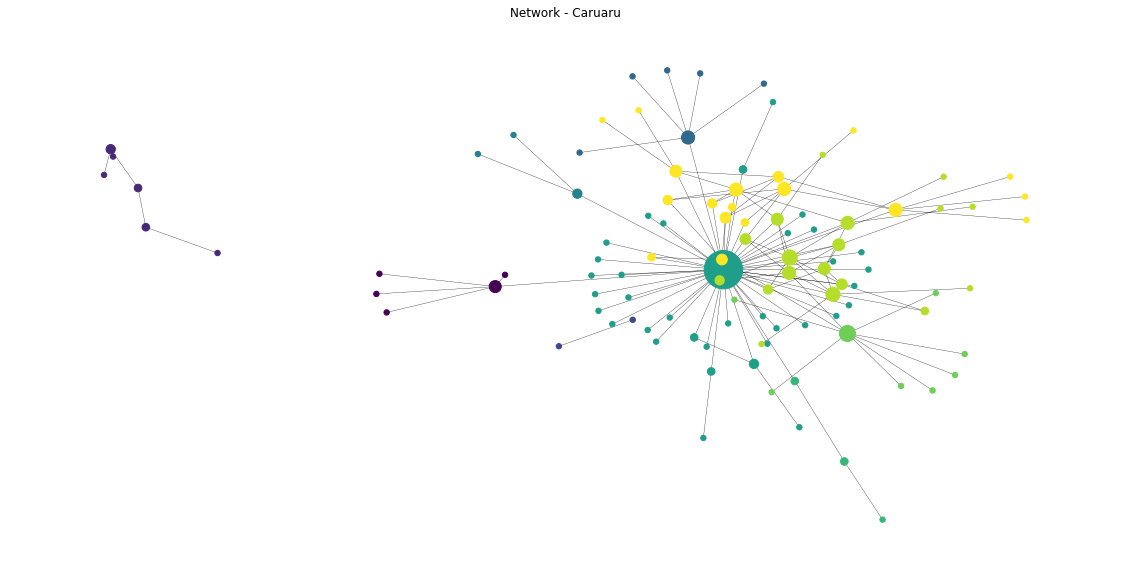

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_com
import numpy as np
import community.community_louvain as community_louvain

# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')

# centrality
deg_centrality = nx.degree_centrality(G)
centrality = np.fromiter(deg_centrality.values(), float)

# modularity
label = community_louvain.best_partition(G)
mod = community_louvain.modularity(label, G)
values = [label.get(node) for node in G.nodes()]


# plot
#pos = nx.spring_layout(G)
pos = nx.spring_layout(G, k=0.8*1/np.sqrt(len(G.nodes())), iterations=15, scale=20)
plt.figure(figsize=(20,10))
plt.title("Network - Caruaru")
plt.axis('off')
nx.draw(G, pos, node_color=values, node_size=centrality*3e3, width=0.3)

# Visualização Interativa de redes utilizando o Bokeh
https://docs.bokeh.org/en/latest/docs/user_guide/graph.html?highlight=networks

In [ ]:
import networkx as nx
!pip install pydot
#Choose a title!
#title = 'Network - Rio de Janeiro'

# create graph from data
#G = nx.Graph()
#G = nx.from_pandas_edgelist(colab_users_rj, 'source', 'target')

#Establish which categories will appear when hovering over each node
#HOVER_TOOLTIPS = [("user_id", "@index")]

#Create a plot — set dimensions, toolbar, and title
#plot = figure(tooltips = HOVER_TOOLTIPS,
#              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
#            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
#network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
#network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
#network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
#plot.renderers.append(network_graph)

#show(plot)
from networkx.algorithms import community as community
#
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
#
def get_adjusted_node_size(graph_network):
  degrees = nx.degree(graph_network)
  nx.set_node_attributes(graph_network, name='degree', values=dict(degrees))
  #
  centrality = nx.eigenvector_centrality_numpy(graph_network)
  nx.set_node_attributes(graph_network, name='centrality', values=centrality)
  centrality_values = []
  degree_values = []
  for (node) in centrality:
    centrality_values.append(centrality[node])
  max_centrality = max(centrality_values)
  min_centrality = min(centrality_values)
  i=0
  for (node, degree) in degrees:
    degree_values.append(degree)
    i=i+1
  max_degree = max(degree_values)
  print("max_degree", max_degree)
  #print("centrality_values", centrality_values)
  #print("max_centrality", max_centrality)
  #print("min_centrality", min_centrality)
  centrality_values=normalize(centrality_values, {'actual': {'lower': min_centrality, 'upper': max_centrality*2}, 'desired': {'lower': 5, 'upper': 100}})
  sizes = {}
  i=0
  for (node, degree) in degrees:
    sizes[node] = centrality_values[i]
    i=i+1
  #print("centrality_values_normalized", centrality_values)
  #print(sizes)
  adjusted_node_size = dict([(node, sizes[node]) for node, degree in degrees])
  nx.set_node_attributes(graph_network, name='adjusted_node_size', values=adjusted_node_size)
#
def plot_bokeh_network(graph_network, network_communities, title, palette):
  for component in list(nx.connected_components(graph_network)):
    if len(component)<3:
        for node in component:
            graph_network.remove_node(node)
  #
  get_adjusted_node_size(graph_network)
  # Create empty dictionaries
  modularity_class = {}
  modularity_color = {}
  #Loop through each community in the network
  for community_number, community in enumerate(network_communities):
      #For each member of the community, add their community number and a distinct color
      for name in community:
          modularity_class[name] = community_number
          modularity_color[name] = palette[community_number%len(palette)]
  # Add modularity class and color as attributes from the network above
  nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
  nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')
  #Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
  size_by_this_attribute = 'adjusted_node_size'
  color_by_this_attribute = 'modularity_color'
  #Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
  color_palette = Blues8
  #Choose colors for node and edge highlighting
  node_highlight_color = 'white'
  edge_highlight_color = 'black'
  #Establish which categories will appear when hovering over each node
  #Establish which categories will appear when hovering over each node
  HOVER_TOOLTIPS = [
          ("user_id", "@index"),
          ("Degree", "@degree"),
          ("Centrality", "@centrality"),
          ("Modularity Class", "@modularity_class"),
          ("Modularity Color", "$color[swatch]:modularity_color"),
  ]

  #Create a plot — set dimensions, toolbar, and title
  plot = figure(tooltips = HOVER_TOOLTIPS,
              sizing_mode="stretch_width",
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', height=600, title=title)
  #

  #df = pd.DataFrame(index=graph_network.nodes(), columns=graph_network.nodes())
  #for row, data in nx.shortest_path_length(graph_network):
  #    for col, dist in data.items():
  #        df.loc[row,col] = dist
  #df = df.fillna(df.max().max())

  #layout = nx.spring_layout(graph_network, scale=10, weight='degree')
  #layout = nx.nx_agraph.graphviz_layout(graph_network)
  layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

  #Create a network graph object
  # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
  network_graph = from_networkx(graph_network, layout, scale=25, k=len(graph_network.nodes())*1/np.sqrt(len(G.nodes())), center=(0, 0))

  #Set node sizes and colors according to node degree (color as category from attribute)
  network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
  #Set node highlight colors
  network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
  network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

  #Set edge opacity and width
  network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=0.5)
  #Set edge highlight colors
  network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  #
  #Highlight nodes and edges
  network_graph.selection_policy = NodesAndLinkedEdges()
  network_graph.inspection_policy = NodesAndLinkedEdges()
  #
  plot.renderers.append(network_graph)

  show(plot)
#
#get_adjusted_node_size(graph_rj)
#normalize(
    #[1, 0.7232322, 0.93832, 0.4344433],
    #{'actual': {'lower': 0, 'upper': 1}, 'desired': {'lower': 5, 'upper': 50}}
#)
#plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Plotando uma rede simples
Plotando a rede de Caruaru utilizando cores para distinguir a centralidade da rede.
Esse foi o exemplo base da documentaçao do Bokeh, que foi evoluido para os exemplos a seguir.

In [ ]:
# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
#Calculate degree for each node and add as node attribute
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)
#Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
#
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Network - Caruaru'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("user_id", "@index"),
        ("Degree", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)

# Colab Network - Caruaru

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

max_degree 51


# Conexões da Rede - Caruaru

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
157493,51
322881,9
313537,8
288189,7
299406,6
...,...
216340,1
253661,1
313457,1
289871,1


# Colab Network - Rio de Janeiro

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Rio de Janeiro', d3['Category20'][20])

max_degree 312


# Conexões da Rede - Rio de Janeiro

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
165510,312
116960,70
5710,69
31366,64
169459,63
...,...
35554,1
101938,1
6249,1
93407,1


# Colab Network - Niteroi

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Niterói', d3['Category20'][20])

max_degree 441


KeyboardInterrupt: ignored

# Conexões da Rede - Niterói

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

NameError: ignored

# Colab Network - Recife

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Recife', d3['Category20'][20])

max_degree 547


# Conexões da Rede - Recife

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
2,547
157493,272
296688,236
19082,232
155379,187
...,...
114704,1
31474,1
108768,1
3700,1


# Merge de dados de geolocalizacao com dataframe de network


In [ ]:
# obtendo dados de localizaçao fake em recife para servir depontos para postagens sem latxlong
# ja foi solicitado ao DBA a lista de eventos com geolocalizaçao, mas a intenção aqui é somente preparar um book com dados de geoloc para usar no gephi
import osmnx as ox
import random
ox.config(use_cache=True, log_console=True)

#G_re = ox.graph_from_place('Recife, Pernambuco, Brazil', network_type='drive')
#Gp = ox.project_graph(G_re)
#points_recife = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G_re))

ModuleNotFoundError: ignored

In [ ]:
# obtendo dados de localizaçao fake no rio para servir depontos para postagens sem latxlong
#G_rj = ox.graph_from_place('Rio de Janeiro, Rio de Janeiro, Brazil', network_type='drive')
#Gp = ox.project_graph(G)
#points_rj = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G))


In [ ]:
# traduzindo o complexo esquema de pontos da lib para uma simples array de latxlng
#latlng_rj = []
#nodes_rj = G_rj.nodes
#for index, poi in pd.DataFrame(points_rj).iterrows():
  #latlng_rj.append(nodes_rj[index[0]])
#latlng_rj
#def setLatLngRJ(v):
  #pos = random.choice(latlng_rj)
  #return [pos['y'], pos['x']]
#
#latlng_re = []
#nodes_re = G_re.nodes
#for index, poi in pd.DataFrame(points_recife).iterrows():
 # latlng_re.append(nodes_re[index[0]])
#latlng_re
#def setLatLngRE(v):
 # pos = random.choice(latlng_re)
  #return [pos['y'], pos['x']]
#

In [ ]:
# esse bloco é temporario. a intençao dele é fazer o merge do arquivo de eventos com geolocalizaçao e o arquivo de eventos novo sem geolocalizaçao
# para os itens que sao nulos, vamos adicionar geolocalizacao fake so para testar no gephi.
# a ideia é gerar outro arquivo csv com esses dados reais uma vez que o dataset de eventos esteja disponivel com a geolocalizaçao
#colab_events_url_niteroi = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
colab_events_url_geo = "https://drive.google.com/uc?id=1u-IhA8TtOh5ilRXurEV7TXYN_VIjrWRg&export=download" #All data - with GEO
colab_events_geo = ReadCSV(colab_events_url_geo, None)

unique_events_by_user = colab_events_geo.drop_duplicates(subset=['user_id'])[['user_id', 'lat', 'lng']]
unique_events_by_user['user_id'] = unique_events_by_user['user_id'].astype('int')
unique_colab_events= unique_events_by_user

df_all = pd.merge(unique_events_by_user, unique_colab_events, on=['user_id'], how='left', indicator=False)
#print("all events", df_all.shape)
#
colab_users_cities = colab_users.drop_duplicates(subset=['colab_user_id'])[['colab_user_id', 'city_name']]
colab_users_cities=colab_users_cities.rename(columns={"colab_user_id":"user_id"})
colab_users_cities = pd.merge(colab_users_cities, df_all, on=['user_id'], how='left', indicator=False)
colab_users_cities=colab_users_cities.rename(columns={"city_name_x":"city_name"})

colab_users_cities
DownloadDataFrame(colab_users_cities, "colab_users_cities.csv")

NameError: ignored

In [ ]:
#for ind, row in colab_users_cities.iterrows():
#  if row['city_name'] == 'Rio de Janeiro':
#      pos = setLatLngRJ(None)
#      colab_users_cities.loc[ ind, 'lat'] = pos[0]
#      colab_users_cities.loc[ ind, 'lng'] = pos[1]
#  elif row['city_name'] == 'Recife':
#      pos = setLatLngRE(None)
#      colab_users_cities.loc[ ind, 'lat'] = pos[0]
#      colab_users_cities.loc[ ind, 'lng'] = pos[1]
#DownloadDataFrame(colab_users_cities, "colab_users_cities_mock.csv")

In [ ]:
DownloadDataFrame(colab_network_niteroi, "colab_network_niteroi.csv")

# Merge de usuários e seus seguidores em um unico csv

In [ ]:
#
# usuários que tem postagens no colab
#
#colab_users_url = "https://drive.google.com/uc?id=1-P0Y9q27tDWQq2HD5PYgySmu1UBlJwO7&export=download" #2020-2022 Niteroi - Clean
#colab_users_url = "https://drive.google.com/uc?id=16gqijd_rNssCV2bWy09cyPJWh4c0ycbe&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1MCyRDc_lty7m2UVKeAFse2vDust2Mtg4&export=download" #05-20 File (all data)
#colab_users = ReadAndValidateColabUsers(colab_users_url)
#print(colab_users.shape)
#colab_users.head(1)
#
# seguidores de usuarios que tem postagens no colab
#
#colab_users_followers_url = "https://drive.google.com/uc?id=125MHZFOmhok7avkMpxZiHEejZt9kLkXQ&export=download" #New File (all data)
#colab_users_followers_url = "https://drive.google.com/uc?id=1lbIpMG_AoQrx_dlkDTqTHl9F7EvLlxyC&export=download" #05-20 File (all data)
#colab_users_followers = ReadAndValidateColabUsers(colab_users_followers_url)
#print(colab_users_followers.shape)
#colab_users_followers.head(1)
##
#df1=colab_users
#df2=colab_users_followers
##
#df_all = pd.concat([colab_users.set_index('colab_user_id'), colab_users_followers.set_index('colab_user_id')], axis='columns', keys=['First', 'Second'])
#df_final = df_all.swaplevel(axis='columns')[colab_users.columns[1:]]
#df_final
#
# concatenando usuários com seus seguidores em uma unica planilha sem duplicados
#
#result = pd.concat([df1,df2])
#idx = np.unique(result["colab_user_id"], return_index=True)[1]
#colab_users_and_followers =result.iloc[idx]
#colab_users_and_followers
#DownloadDataFrame(colab_users_and_followers, "colab_users_and_followers.csv")